# A demonstration of OMpy


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import ompy as om

import logging

<IPython.core.display.Javascript object>


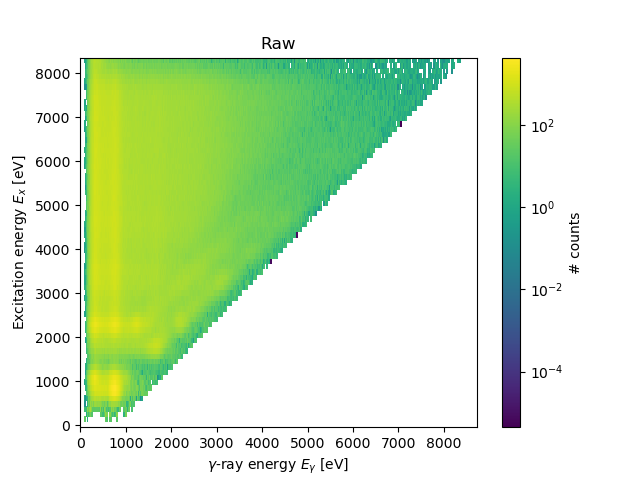

In [27]:
# Import raw matrix into instance of om.Matrix() and plot it
raw = om.load_example_raw('Dy164')
raw.cut_diagonal((800, 0), (7500, 7300))
raw.cut(axis='Ex', limits=[0, 8400])

# Plot the entire matrix
raw.plot()

<IPython.core.display.Javascript object>


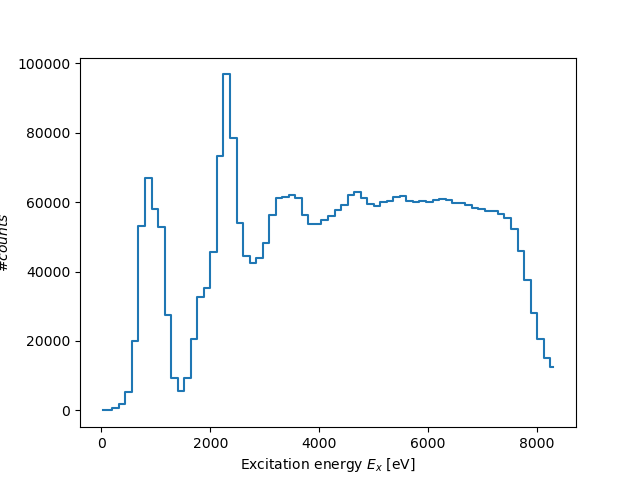

In [28]:
# Plot projections
raw.plot_projection('Ex')

<IPython.core.display.Javascript object>


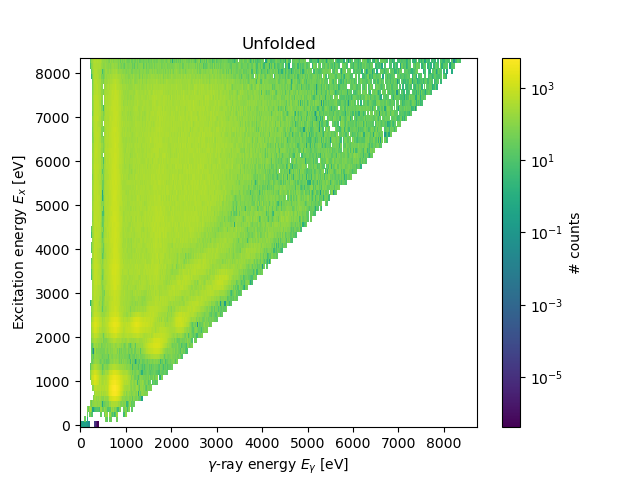

In [29]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("ompy.unfolder")
logger.setLevel(logging.INFO)

fname_resp_mat = "../data/Dy164_response_matrix.m"
fname_resp_dat = "../data/Dy164_response_parameters.dat"

unfolder = om.Unfolder()
unfolder.load_response(fname_resp_mat)
unfolded = unfolder.unfold(raw)
unfolded.plot()

Hello from the fill_negative() function. Please debug me.


<IPython.core.display.Javascript object>


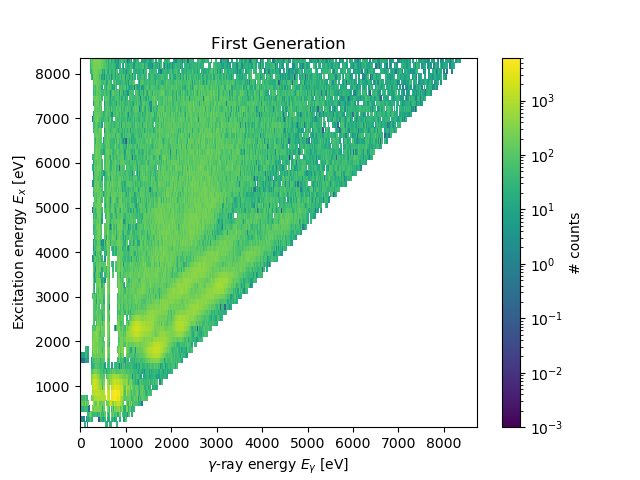

In [30]:
firstgen = om.first_generation_method(unfolded, Ex_max=8500, dE_gamma=500)
firstgen.plot(zmin=1e-3)

In [32]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
logger = logging.getLogger("ompy.ensemble")
logger.setLevel(logging.INFO)

unfolder = om.Unfolder()
unfolder.cut_diagonal((800, 0), (7500, 7300))
unfolder.load_response(fname_resp_mat)
unfolded = unfolder.unfold(raw)

def firstmethod(U):
    return om.first_generation_method(matrix_in=U, Ex_max=8500,
                        dE_gamma=800,multiplicity_estimation="statistical")

ensemble = om.Ensemble(raw=raw)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstmethod
ensemble.generate(number=10, regenerate=True)


INFO:ompy.ensemble:Generating 0

INFO:ompy.ensemble:Generating 1
INFO:ompy.ensemble:Generating 2
INFO:ompy.ensemble:Generating 3
INFO:ompy.ensemble:Generating 4
INFO:ompy.ensemble:Generating 5
INFO:ompy.ensemble:Generating 6
INFO:ompy.ensemble:Generating 7
INFO:ompy.ensemble:Generating 8
INFO:ompy.ensemble:Generating 9


<IPython.core.display.Javascript object>


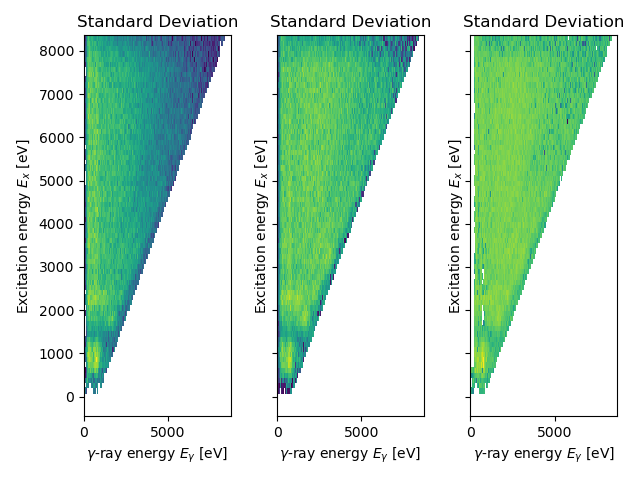

In [33]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ensemble.std_raw.plot(ax=ax[0])
ensemble.std_unfolded.plot(ax=ax[1])
ensemble.std_firstgen.plot(ax=ax[2])
plt.tight_layout()
plt.show()

In [46]:
bin_width_out = 150
Ex_min = 4000
Ex_max = 8000
Eg_min = 1000

ftol = 1e-4 # Fitting tolerance (in some unknown, relative units)
maxfev = 9000 # maximum number of function evaluations

N_fits = 10

In [47]:
# Decomposition with the new 1Gen matrixes -- if saved, just load them again

rho_ens = []
gsf_ens = []
try:
    nld_Earray = np.loadtxt("error_propagation_ensemble/rho_E_array.txt")
    gsf_Earray = np.loadtxt("error_propagation_ensemble/gsf_E_array.txt")
    for i in range(N_fits):
        rho_val = np.loadtxt("error_propagation_ensemble/rho_ensemble_fits-{:d}.txt".format(i))
        gsf_val = np.loadtxt("error_propagation_ensemble/gsf_ensemble_fits-{:d}.txt".format(i))
        rho = om.Vector(rho_val, nld_Earray)
        rho_ens.append(rho)
        gsf = om.Vector(gsf_val, gsf_Earray)
        gsf_ens.append(gsf)
except:
    std = ensemble.std_firstgen
    for i in range(N_fits):
        print("Start of iteration {}".format(i))
        mat = om.Matrix(ensemble.firstgen_ensemble[i],
                     Ex=std.Ex,
                     Eg=std.Eg)
        fits = om.FitRhoT(mat, std, bin_width_out,
                              Ex_min, Ex_max, Eg_min,
                              method="Powell",
                              options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                              #error_normalization="approximate"
                             )
        rho_ens.append(fits.rho)
        T = fits.T
        gsf = T.values / (2 * np.pi * (T.E_array)**3)
        gsf_ens.append(om.Vector(gsf,T.E_array))

        np.savetxt("error_propagation_ensemble/rho_ensemble_fits-{:d}.txt".format(i), rho_ens[i].values)
        np.savetxt("error_propagation_ensemble/gsf_ensemble_fits-{:d}.txt".format(i), gsf_ens[i].values)

    np.savetxt("error_propagation_ensemble/rho_E_array.txt", rho_ens[0].E)
    np.savetxt("error_propagation_ensemble/gsf_E_array.txt", gsf_ens[0].E)

rho_ens_initial = rho_ens
gsf_ens_initial = gsf_ens

<IPython.core.display.Javascript object>


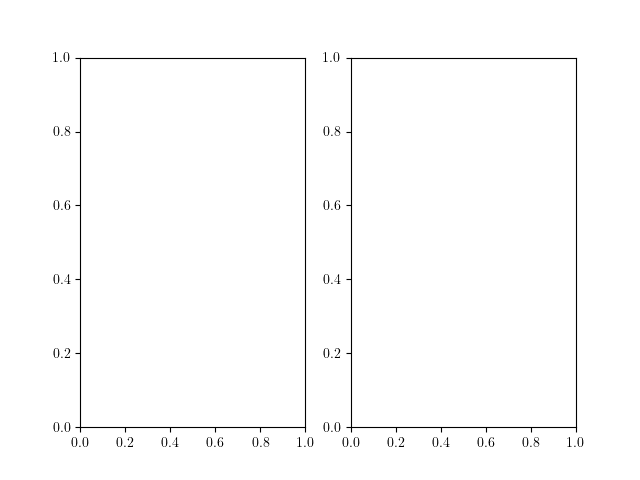

AttributeError: 'Vector' object has no attribute 'E_array'

In [48]:
# Do the fits look the same (using the previously estimated 1Gen matrix and the updated version)?
def plot_nld_gsf(rho_ens, gsf_ens):
    fig, (ax1,ax2) = plt.subplots(1,2) 
    for i in range(10):
        ax1.plot(rho_ens[i].E_array, rho_ens[i].values, "-", label=str(i), alpha=0.5)
        ax2.plot(gsf_ens[i].E_array, gsf_ens[i].values, "-", alpha=0.5)
    ax1.set_yscale("log")
    ax1.legend()
    ax2.set_yscale("log")
    plt.plot()

plot_nld_gsf(rho_ens_initial, gsf_ens_initial)

[0.58588011 0.10483301 0.12940397 0.08211982 0.09652559 0.08608802
 0.08748797 0.14015799 0.13507523 0.08025532 0.1162451  0.08677161
 0.09893984 0.14793067 0.08410514 0.09720717 0.15010363 0.06041519
 0.13186008 0.06951881 0.10112047 0.07659861 0.04027149 0.06737081
 0.07520781 0.08161685 0.11595081 0.07484959 0.07734833 0.06904365
 0.10323929 0.07634994 0.20648592 0.09145286 0.16312222 0.12164275
 0.11868785 0.1663344  0.18431967 0.15594742 0.12625206 0.18028992
 0.19334769 0.16520707 0.18419774 0.19904659 0.19995514 0.29881843
 0.23699808]


<IPython.core.display.Javascript object>


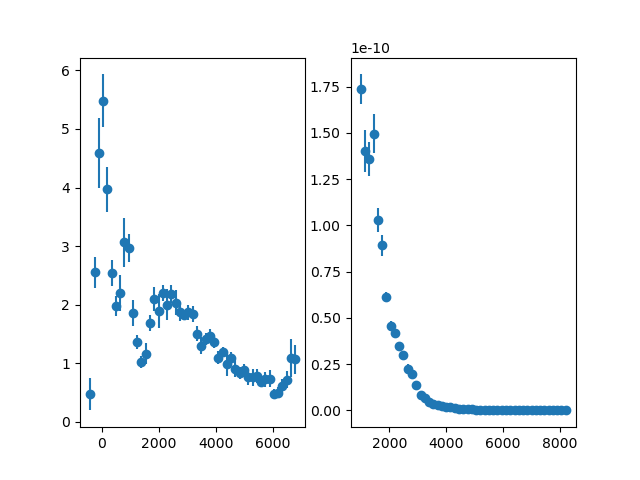

<ErrorbarContainer object of 3 artists>

In [36]:
# plot initial rho and gsf
rho_mean = np.mean([vec.values for vec in rho_ens_initial], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens_initial], axis=0)

rho_std = np.std([vec.values for vec in rho_ens_initial], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens_initial], axis=0)
print(rho_std/rho_mean)

fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.errorbar(rho_ens[0].E_array, rho_mean, yerr=rho_std, fmt="o")
ax2.errorbar(gsf_ens[0].E_array, gsf_mean, yerr=gsf_std, fmt="o")

In [37]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('errorbar', capsize=1.5) # Set error bar style

In [45]:
import copy
# just giving it a try
alpha = 2
A = 1
B = 10

rho_ens_initialMeV = copy.deepcopy(rho_ens_initial)
gsf_ens_initialMeV = copy.deepcopy(gsf_ens_initial)

E_array = rho_ens_initial[0].E_array/1e3
for i in range(len(rho_ens_initialMeV)):
    rho_ens_initialMeV[i].E_array = E_array
    
E_array = gsf_ens_initial[0].E_array/1e3
for i in range(len(rho_ens_initialMeV)):
    gsf_ens_initialMeV[i].E_array = E_array

rho_ens = [vec.transform(alpha=alpha, const=A) for vec in rho_ens_initialMeV]
gsf_ens = [vec.transform(alpha=alpha, const=B) for vec in gsf_ens_initialMeV]

rho_mean = np.mean([vec.values for vec in rho_ens], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens], axis=0)

rho_std = np.std([vec.values for vec in rho_ens], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens], axis=0)

yscale ="log"
fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.errorbar(rho_ens[0].E_array, rho_mean, yerr=rho_std, fmt="o")
ax2.errorbar(gsf_ens[0].E_array, gsf_mean, yerr=gsf_std, fmt="o")
ax1.set_yscale(yscale)
ax2.set_yscale(yscale)

ax1.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
ax2.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")

ax1.set_xlabel(r"$E_x (\mathrm{MeV})$")
ax2.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

# Load and add published, normalized data:
rho_published = np.loadtxt("Dy164/data/rho164dy.txt", skiprows=2)
ax1.errorbar(rho_published[:, 1], rho_published[:, 2], yerr=rho_published[:, 3],
                      fmt="<", markersize=2, color="crimson",
                      label=r"$\rho$, Nyhus $\textit{et\,\,al.}$")

gsf_published = np.loadtxt("Dy164/data/rsf164dy.txt", skiprows=2)
ax2.errorbar(gsf_published[:, 1], gsf_published[:, 2], yerr=gsf_published[:, 3],
                      fmt="<", markersize=2, color="crimson",
                      label=r"$\gamma$SF, Nyhus $\textit{et\,\,al.}$")


plt.tight_layout()
plt.plot()

AttributeError: 'Vector' object has no attribute 'E'

In [13]:
# find_norm

pnld_norm = {}
pnld_norm["E1_low"] = 1.
pnld_norm["E2_low"] = 2.
pnld_norm["E1_high"] = 3.5
pnld_norm["E2_high"] = 6.5
pnld_norm["nld_Sn"] = np.array([7.658, 2.36e6])
pnld_ext = {} # automatically found for CT
pnld_ext["ext_range"] = np.array([6.,8.]) # extrapolation range
fname_discretes = "Dy164/data/discrete_levels.txt"

rho_initial_mean = np.mean([vec.values for vec in rho_ens_initial], axis=0)
rho_initial_std = np.std([vec.values for vec in rho_ens_initial], axis=0)
nld = np.c_[rho_ens_initial[0].E_array*1e-3, rho_initial_mean, rho_initial_std]

print("Uncs:", nld[:,2]/nld[:,1])

# Bounds for differential evolution
# A, alpha, T
pnld_norm["bounds_diff_evo"] = [(1e-3, 100), (1e-1, 1e1), (0.1, 1)]
normNLD = om.NormNLD(nld=nld,
                     method="find_norm", pnorm=pnld_norm,
                     nldModel="CT", pext=pnld_ext,
                     fname_discretes=fname_discretes )

rho_fit = normNLD.nld_norm
nld_ext = normNLD.nld_ext
A_norm = normNLD.A_norm
alpha_norm = normNLD.alpha_norm
discretes = normNLD.discretes


Uncs: [0.51001206 0.06732853 0.10545267 0.06935075 0.07413862 0.09735908
 0.07330168 0.12697412 0.1204299  0.09071361 0.13699901 0.05144875
 0.10868237 0.09325601 0.15252706 0.0507347  0.12724816 0.06437339
 0.06109114 0.08114209 0.13881741 0.11887188 0.0689491  0.04420827
 0.08363766 0.08339063 0.06492636 0.07320193 0.11649778 0.15717905
 0.08389429 0.14243671 0.11075559 0.07642467 0.14841408 0.09446585
 0.14772719 0.13318785 0.11360209 0.17994276 0.15048339 0.12075463
 0.15116212 0.18058738 0.15166435 0.09395819 0.1800752  0.20601142
 0.25446554]
Result from find_norm / differential evolution:
      fun: 68.61098238148617
     jac: array([-5.68434189e-06, -3.97903932e-05, -1.42108547e-05])
 message: 'Optimization terminated successfully.'
    nfev: 1574
     nit: 33
 success: True
       x: array([1.15831089, 2.03001535, 0.59092038])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks
  analysing data from multinest/nld_norm_.txt
    A              1.161 +- 0.046
   

2.0301257365345418


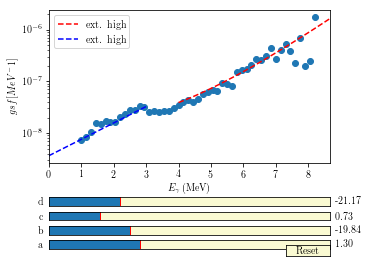

In [14]:
## normalization of the gsf
# choose a spincut model and give it's parameters
spincutModel="EB05"
spincutPars={"mass":164, "NLDa":17.75, "Eshift":0.38} # some dummy values

makePlot = True
interactive = True 
# input parameters:
# Emid_Eg, rho_in, T_in in MeV, MeV^-1, 1
# Jtarget in 1
# D0 in eV
# Gg in meV
# Sn in MeV
Jtarget = 0
D0 = 62 # eV (of the A-1 nucleus(!))
Gg = 113 # meV
Sn = 7.658 # MeV

# extrapolations
gsf_ext_range = np.array([0,3.,4., Sn+1])
pext = {'gsf_ext_low': np.array([  0.72980763, -21.17427936]),
 'gsf_ext_high': np.array([  1.29711533, -19.83504859])}
print(alpha_norm)
# assumptions in normalization: swave (currently); and equal parity
normMethod="standard" #-- like in normalization.c/Larsen2011 eq (26)
# normMethod="test" # -- test derived directly from Bartolomew

try:
    dim = rho_fit.shape[1]
    if dim == 3:
        rho_fit_err = rho_fit[:,2]
        rho_fit_mean = rho_fit[:,1]
    elif dim == 2:
        rho_fit_mean = rho_fit[:,1]
except IndexError:
        pass

gsf_ens = [vec for vec in gsf_ens_initialMeV]
gsf_mean = np.mean([vec.values for vec in gsf_ens], axis=0)
#gsf_std = np.std([vec.values for vec in gsf_ens], axis=0)

normGSF = om.NormGSF(gsf=np.c_[gsf_ens[0].E_array,gsf_mean],
                       method=normMethod,
                       Jtarget=Jtarget, D0=D0, Gg=Gg, Sn=Sn,
                       alpha_norm=alpha_norm,
                       pext=pext, ext_range = gsf_ext_range,
                       spincutModel=spincutModel, spincutPars=spincutPars,
                       nld=np.c_[rho_ens[0].E_array,rho_fit_mean], nld_ext=nld_ext)

normGSF.normalizeGSF(makePlot=makePlot,
                     interactive=interactive)

[]

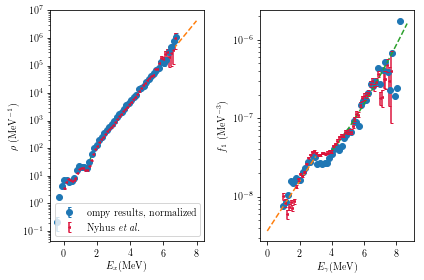

In [15]:
gsf_fit = normGSF.gsf
gsf_ext_low = normGSF.gsf_ext_low
gsf_ext_high = normGSF.gsf_ext_high
pars = normGSF.pext

yscale ="log"
fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.errorbar(rho_fit[:,0],rho_fit[:,1],yerr=rho_fit[:,2],fmt="o",
             label=r"ompy results, normalized")
ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")
ax1.plot(discretes[:,0],discretes[:,1],"-")
ax1.set_yscale(yscale)

ax2.plot(gsf_fit[:,0],gsf_fit[:,1],"o")
ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")
ax2.set_yscale(yscale)


ax1.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
ax2.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")

ax1.set_xlabel(r"$E_x (\mathrm{MeV})$")
ax2.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

# Load and add published, normalized data:
rho_published = np.loadtxt("Dy164/data/rho164dy.txt", skiprows=2)
ax1.errorbar(rho_published[:, 1], rho_published[:, 2], yerr=rho_published[:, 3],
                      fmt="<", markersize=2, color="crimson",
                      label=r"Nyhus $\textit{et\,\,al.}$")
ax1.legend()

gsf_published = np.loadtxt("Dy164/data/rsf164dy.txt", skiprows=2)
ax2.errorbar(gsf_published[:, 1], gsf_published[:, 2], yerr=gsf_published[:, 3],
                      fmt="<", markersize=2, color="crimson",
                      label=r"Nyhus $\textit{et\,\,al.}$")


plt.tight_layout()
plt.plot()